## Przypomnienie
Analiza składowych głównych (ang. principal component analysis, PCA) polega na rzutowaniu danych na nową przestrzeń, w której poszczególne składowe są względem siebie ortogonalne. Nowe składowe są kombinacją liniową (sumą ważoną) analizowanych zmiennych.

PCA jest wykorzystywane w różnych celach:
- redukcji wymiarowości,
- kompresji sygnałów,
- eksploracji danych i klasteryzacji.

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


## PCA na przykładzie MFCC

Na zajęciach zastosujemy PCA do redukcji wymiarowości danych akustycznych. Pomocny może być przykładowy notatnik, który zawiera wszystkie kroki analizy.

Na początek wyekstrahujemy 13 MFCC oraz policzymy ich pierwszą i drugą pochodną (poniżej jest fragment kodu pokazujący, jak to zrobić) z dowolnego sygnału z poprzednich zajęć. Pierwsza pochodna jest określana jako $\Delta$, a druga jako $\Delta^2$ lub czasem $\Delta\Delta$.

In [ ]:
data, fs = librosa.load('dane_testowe/1-phrase.wav')

In [3]:
mfcc_features = librosa.feature.mfcc(y=data, sr=fs, n_mfcc=13)
mfcc_delta = librosa.feature.delta(mfcc_features)
mfcc_delta2 = librosa.feature.delta(mfcc_features, order=2)

Wyświetlmy MFCC oraz obie pochodne, żeby zobaczyć, jak wyglądają (kod wzięty [z dokumentacji](https://librosa.org/doc/main/generated/librosa.feature.delta.html)).

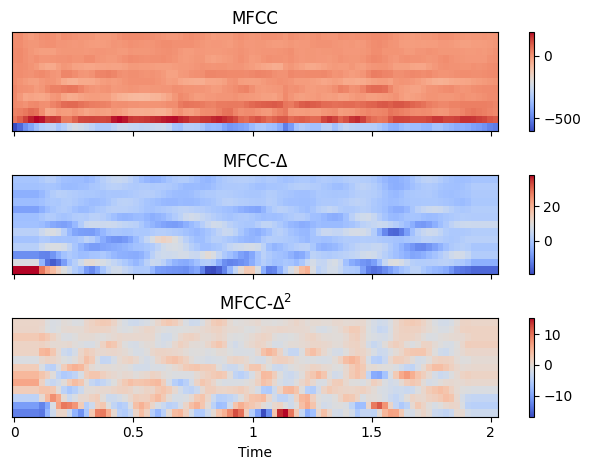

In [ ]:
# tworzymy trzy wykresy jeden pod drugim, z wspólną osią x i y
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
# korzystamy z wbudowanej funkcji do wyświetlania spektrogramów
img1 = librosa.display.specshow(mfcc_features, ax=ax[0], x_axis='time')
ax[0].set(title='MFCC')
ax[0].label_outer()
img2 = librosa.display.specshow(mfcc_delta, ax=ax[1], x_axis='time')
ax[1].set(title=r'$\Delta$MFCC')
ax[1].label_outer()
img3 = librosa.display.specshow(mfcc_delta2, ax=ax[2], x_axis='time')
ax[2].set(title=r'$\Delta^2$MFCC')

fig.tight_layout() # czytelne rozmieszczenie wykresów - colorbar niestety nie podlega tej funkcji, więc musimy dorysować go później:
fig.colorbar(img1, ax=[ax[0]])
fig.colorbar(img2, ax=[ax[1]])
fig.colorbar(img3, ax=[ax[2]])

W pliku `phrase_files.csv` jest gotowa lista plików z etykietami. Wczytaj je do DataFrame; po wczytaniu przypisz pliki i etykiety do osobnych zmiennych.

Następnie wylicz MFCC oraz obie pochodne dla sygnałów. Pamiętaj, żeby wszystkie cechy dodać do jednej macierzy (dla każdego sygnału macierz powinna mieć wymiary 39 x liczba_ramek). Ponieważ sygnały mają różną długość, znajdź liczbę ramek najkrótszego z nich i odpowiednio skróć macierze cech pozostałych sygnałów.

In [99]:
df = pd.read_csv('phrase_files.csv')
# dwa warianty odwołań do kolumny DataFrame:
files = df.file
y = df['label']


Podziel dane na zbiór uczący i testowy i przeprowadź klasyfikację (użyj metody k najbliższych sąsiadów z poprzednich zajęć - skopiuj swój kod). Wylicz też metryki (dokładność, precyzję, czułość, F1-score).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

Teraz na zbiorze uczącym i testowym zastosujemy PCA. 

Pamiętajmy, że na początek musimy przeprowadzić standaryzację danych, ponieważ PCA jest wrażliwe na rząd wielkości danych i bez standaryzacji wyniki mogą wyjść dużo gorsze. Można to zrobić np. używając klasy [`preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) z bilbioteki scikit-learn.

Na początek dobrze jest wziąć dość dużą liczbę składowych, żeby zobaczyć, ile będzie potrzebnych do wyjaśnienia łącznie co najmniej 90% zmienności.

Skoro już wiemy, ile składowych jest potrzebnych, przeprowadzimy klasyfikację na nich, zamiast na MFCC. Wyliczymy te same metryki.

Jak zmieniły się wyniki względem tych uzyskanych pierwszym klasyfikatorem?